## 🧪Experiment For The Paper **"A COMPARATIVE STUDY OF MACHINE LEARNING AND DEEP LEARNING MODELS FOR TEXT CLASSIFICATION ON THE REUTERS DATASET"**

In [6]:
!pip install nltk # NLTK 설치

In [7]:
import nltk
nltk.download('stopwords') # stopwords 다운로드

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import gensim.downloader as api

In [2]:
# Load Reuters dataset
words = 5000
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=words, test_split=0.2)

### 1. Exploratory Data Analysis (EDA)

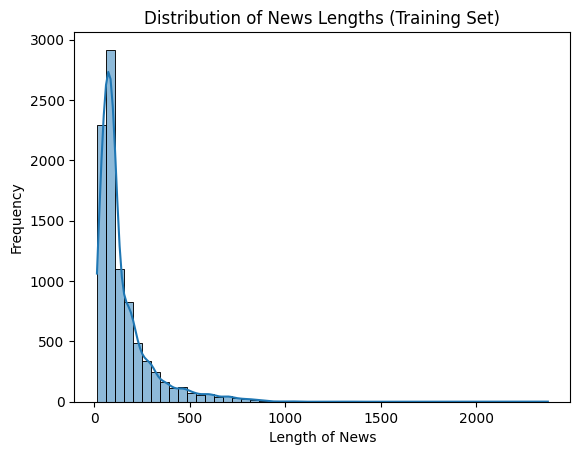

In [3]:
# Distribution of news lengths
news_lengths = [len(x) for x in x_train]
sns.histplot(news_lengths, bins=50, kde=True)
plt.title('Distribution of News Lengths (Training Set)')
plt.xlabel('Length of News')
plt.ylabel('Frequency')
plt.show()

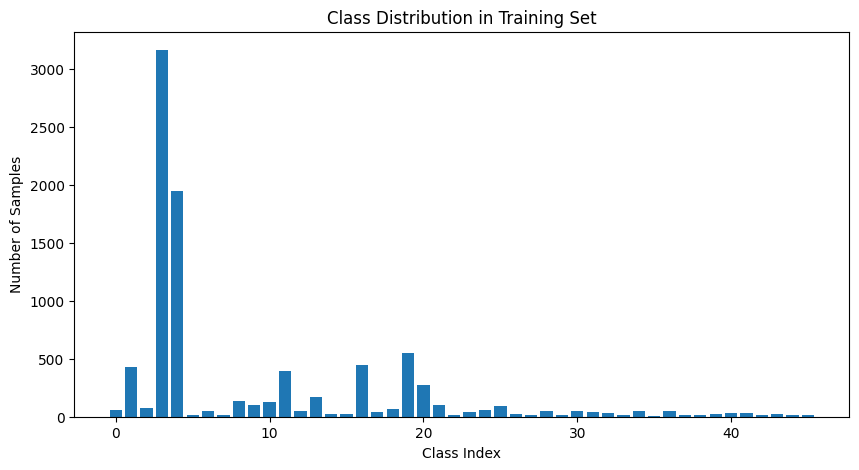

In [4]:
# Class distribution in the training set
class_counts = np.bincount(y_train)
plt.figure(figsize=(10, 5))
plt.bar(range(len(class_counts)), class_counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class Index')
plt.ylabel('Number of Samples')
plt.show()

### 2. Data Preprocessing

In [9]:
# Data Preprocessing: Add steps for stopword removal and stemming for machine learning models
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

class TextPreprocessor(TransformerMixin):
    def transform(self, X, **transform_params):
        return [' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words]) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

x_train_text = [' '.join(map(str, x)) for x in x_train]
x_test_text = [' '.join(map(str, x)) for x in x_test]

preprocessor = TextPreprocessor()
x_train_text = preprocessor.fit_transform(x_train_text)
x_test_text = preprocessor.transform(x_test_text)

mlb = CountVectorizer(max_features=5000)
x_train_ml = mlb.fit_transform(x_train_text)
x_test_ml = mlb.transform(x_test_text)

In [10]:
# Prepare data for DL model
word_index = reuters.get_word_index()
index_word = {v + 3: k for k, v in word_index.items()}
index_word[0], index_word[1], index_word[2] = "<PAD>", "<START>", "<UNK>"

def decode_news(sequence):
    return ' '.join([index_word.get(i, '?') for i in sequence])

# Tokenize and pad sequences for DL model
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train_text)
x_train_seq = tokenizer.texts_to_sequences(x_train_text)
x_test_seq = tokenizer.texts_to_sequences(x_test_text)

x_train_padded = pad_sequences(x_train_seq, maxlen=300)
x_test_padded = pad_sequences(x_test_seq, maxlen=300)

num_classes = np.max(y_train) + 1
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Load pre-trained word2vec embeddings
glove_vectors = api.load("glove-wiki-gigaword-100")
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors:
        embedding_matrix[i] = glove_vectors[word]

[==================================================] 100.0% 128.1/128.1MB downloaded


In [11]:
# Prepare data for DL model
word_index = reuters.get_word_index()
index_word = {v + 3: k for k, v in word_index.items()}
index_word[0], index_word[1], index_word[2] = "<PAD>", "<START>", "<UNK>"

def decode_news(sequence):
    return ' '.join([index_word.get(i, '?') for i in sequence])

# Tokenize and pad sequences for DL model
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train_text)
x_train_seq = tokenizer.texts_to_sequences(x_train_text)
x_test_seq = tokenizer.texts_to_sequences(x_test_text)

x_train_padded = pad_sequences(x_train_seq, maxlen=300)
x_test_padded = pad_sequences(x_test_seq, maxlen=300)

num_classes = np.max(y_train) + 1
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [12]:
# Load pre-trained word2vec embeddings
glove_vectors = api.load("glove-wiki-gigaword-100")
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors:
        embedding_matrix[i] = glove_vectors[word]

### 3. Defining Models

3.1. Defining traditional ML Models : Naive Bayes & SVM

In [13]:
# Define ML models
ml_models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True)
}

3.2. Defining DL Model : CNN + LSTM

In [14]:
# Define DL model
dl_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, weights=[embedding_matrix], input_length=300, trainable=False),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

dl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dl_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │         499,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 499,900 (1.91 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 499,900 (1.91 MB)

### 4. Train and Evaluation

4.1. Train and Evaluate Traditional ML Models : Naive Bayes & SVM

In [15]:
ml_results = []

def evaluate_ml_model(name, model, x_train, y_train, x_test, y_test):
    start_time = time.time()
    process = psutil.Process()
    start_memory = process.memory_info().rss

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    end_memory = process.memory_info().rss
    memory_usage = (end_memory - start_memory) / (1024 * 1024)  # Convert to MB
    end_time = time.time()
    training_time = end_time - start_time

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    ml_results.append((name, accuracy, precision, recall, f1, training_time, memory_usage))
    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Memory Usage: {memory_usage:.2f} MB")
    return y_pred

# Evaluate ML models
y_preds_ml = {}
for name, model in ml_models.items():
    y_preds_ml[name] = evaluate_ml_model(name, model, x_train_ml, y_train, x_test_ml, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m


Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.68      0.77      0.72       105
           2       0.70      0.70      0.70        20
           3       0.96      0.87      0.91       813
           4       0.77      0.91      0.84       474
           5       1.00      0.40      0.57         5
           6       0.85      0.79      0.81        14
           7       1.00      1.00      1.00         3
           8       0.70      0.74      0.72        38
           9       0.67      0.88      0.76        25
          10       0.74      0.87      0.80        30
          11       0.67      0.71      0.69        83
          12       0.88      0.54      0.67        13
          13       0.52      0.78      0.62        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16       0.69      0.76      0.72 

4.2. Train and Evaluate DL Model : CNN + LSTM

In [16]:
# Train DL model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
start_time = time.time()
process = psutil.Process()
start_memory = process.memory_info().rss

history = dl_model.fit(x_train_padded, y_train_cat, epochs=20, batch_size=64, validation_data=(x_test_padded, y_test_cat), callbacks=[early_stopping])

end_memory = process.memory_info().rss
memory_usage = (end_memory - start_memory) / (1024 * 1024)  # Convert to MB
end_time = time.time()
training_time = end_time - start_time

# Evaluate DL model
loss, accuracy = dl_model.evaluate(x_test_padded, y_test_cat)
dl_results = [('CNN + LSTM', accuracy, training_time, memory_usage)]
print(f"Training Time: {training_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")

y_pred_dl = dl_model.predict(x_test_padded).argmax(axis=1)

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 27s 172ms/step - accuracy: 0.3031 - loss: 2.8703 - val_accuracy: 0.4791 - val_loss: 2.1372
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 165ms/step - accuracy: 0.4533 - loss: 2.1843 - val_accuracy: 0.4826 - val_loss: 2.0474
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 0.4606 - loss: 2.1307 - val_accuracy: 0.4898 - val_loss: 2.0089
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - accuracy: 0.4772 - loss: 2.0569 - val_accuracy: 0.4942 - val_loss: 2.0092
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 0.4832 - loss: 2.0278 - val_accuracy: 0.4929 - val_loss: 1.9846
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 161ms/step - accuracy: 0.4773 - loss: 2.0325 - val_accuracy: 0.5080 - val_loss: 1.9097
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.4940 - loss: 1.9847 - val_accuracy: 0.4715 - val_loss: 2.0035
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 172ms/step - accuracy: 0.4866 - loss: 1

### 5. Visualization

In [17]:
# Visualization Functions
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(15, 12))  # Increase figure size for better readability
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=10)  # Rotate labels and adjust font size
    plt.yticks(tick_marks, classes, fontsize=10)
    fmt = 'd'  # Use integer format for confusion matrix values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] > 0:  # Only annotate cells with non-zero values
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=8)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#### 5.1. Visualization of Performance

5.1.1. ML Performance

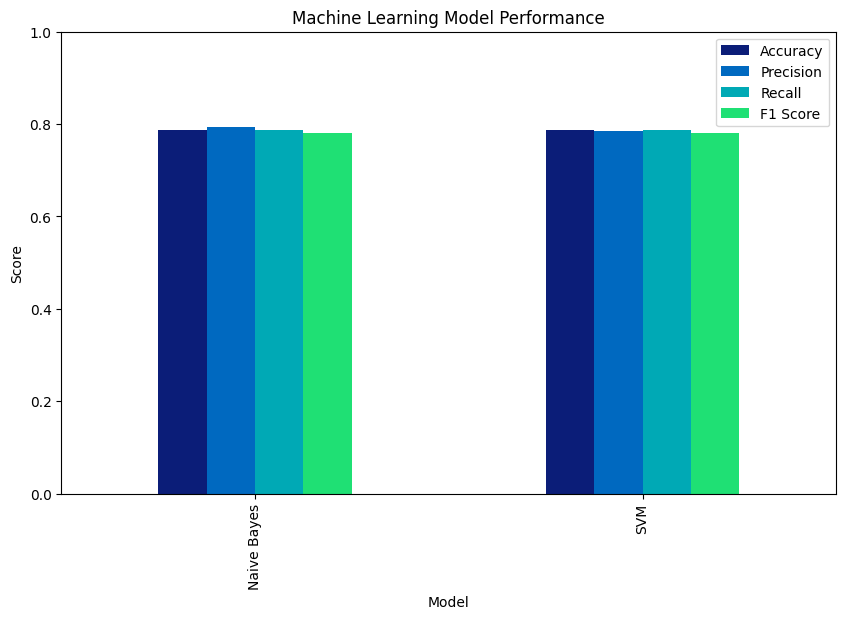

In [29]:
# color=['#FF6347', '#4682B4', '#32CD32', '#FFD700']
# Visualization of ML Performance
ml_results_df = pd.DataFrame(ml_results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Training Time (s)', 'Memory Usage (MB)'])
ml_results_df.set_index('Model', inplace=True)
ml_results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar', figsize=(10, 6), color=['#0b1d78', '#0069c0', '#00a9b5', '#1fe074'])
plt.title('Machine Learning Model Performance')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

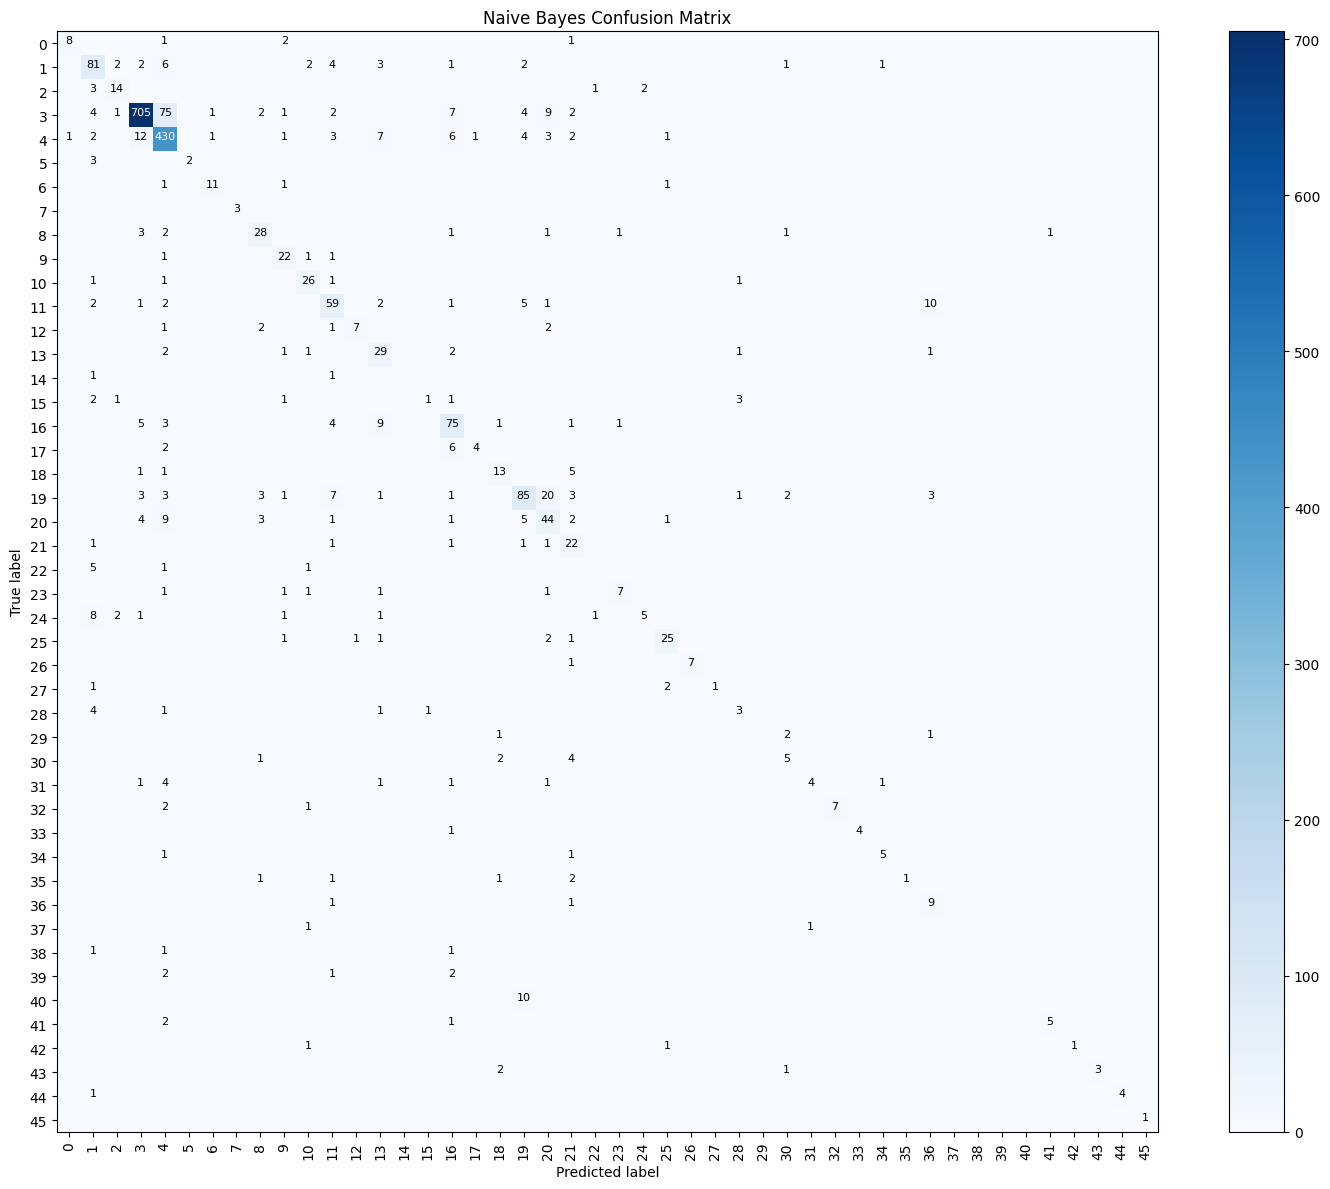

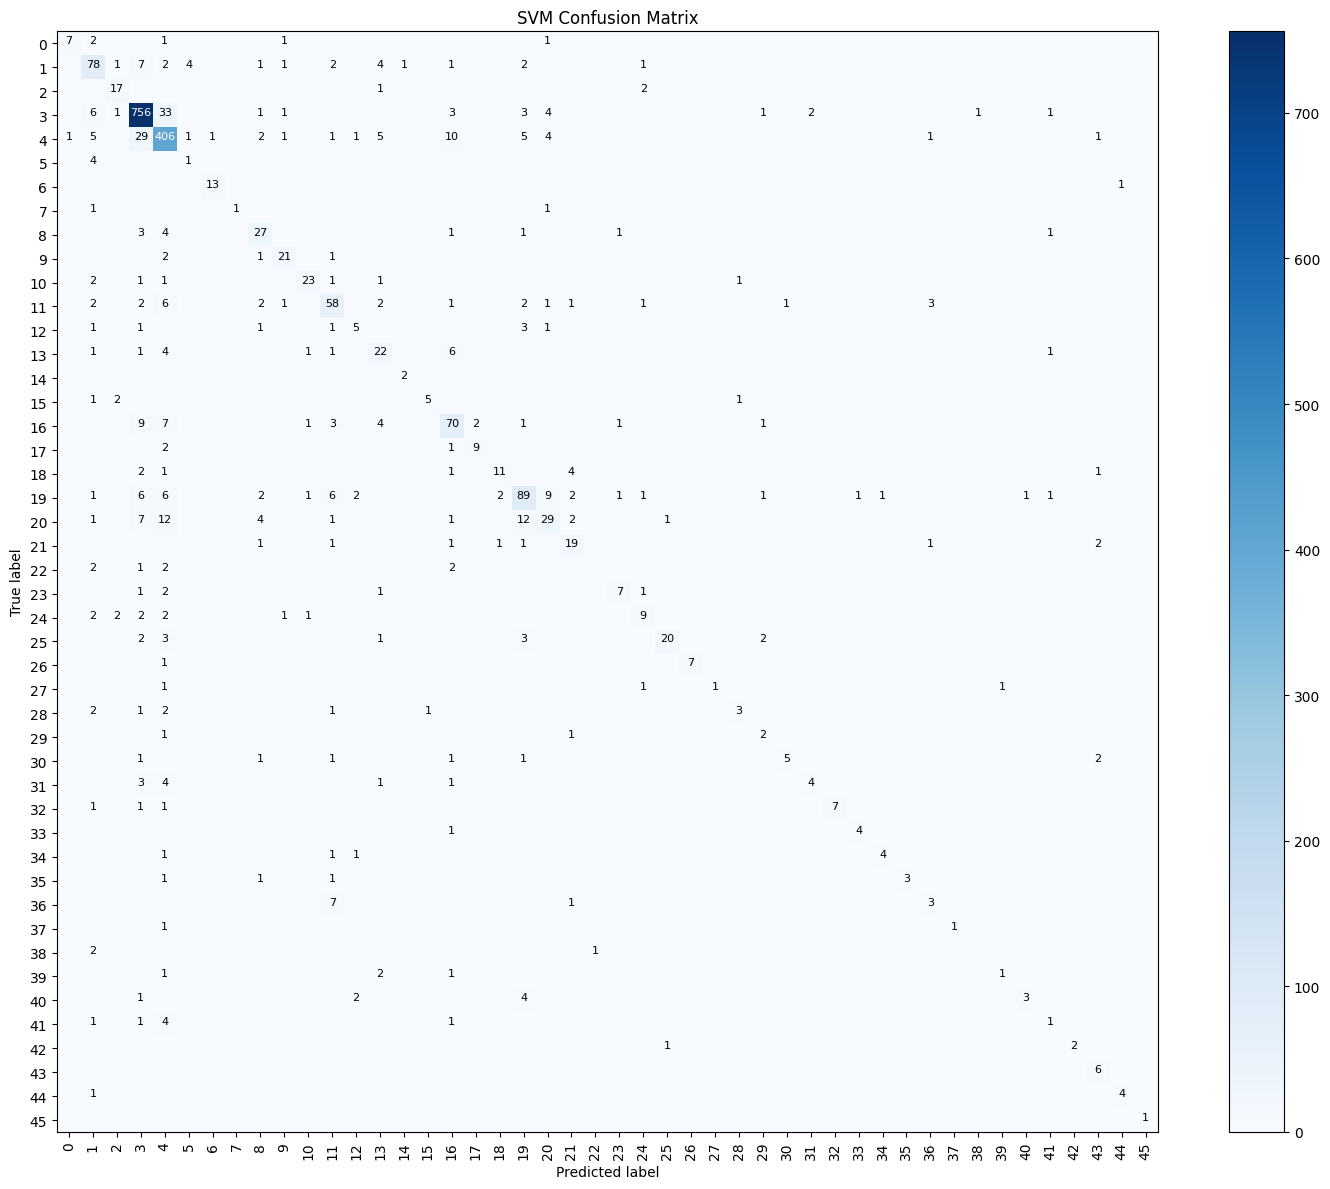

In [19]:
# Confusion Matrices for ML Models
for name, y_pred in y_preds_ml.items():
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=np.unique(y_train), title=f'{name} Confusion Matrix')
    plt.show()

5.1.2. DL Performance

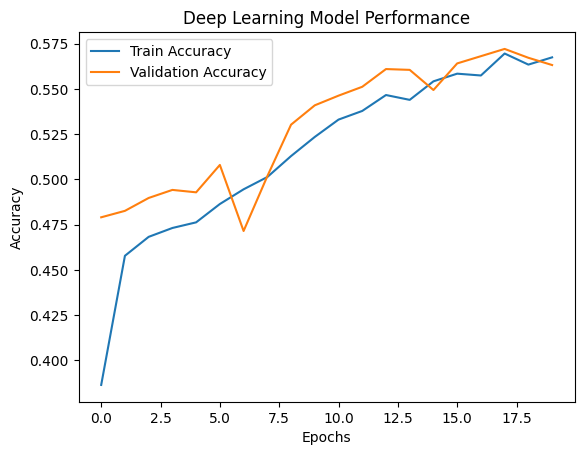

In [20]:
# Visualization of DL Performance
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Deep Learning Model Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

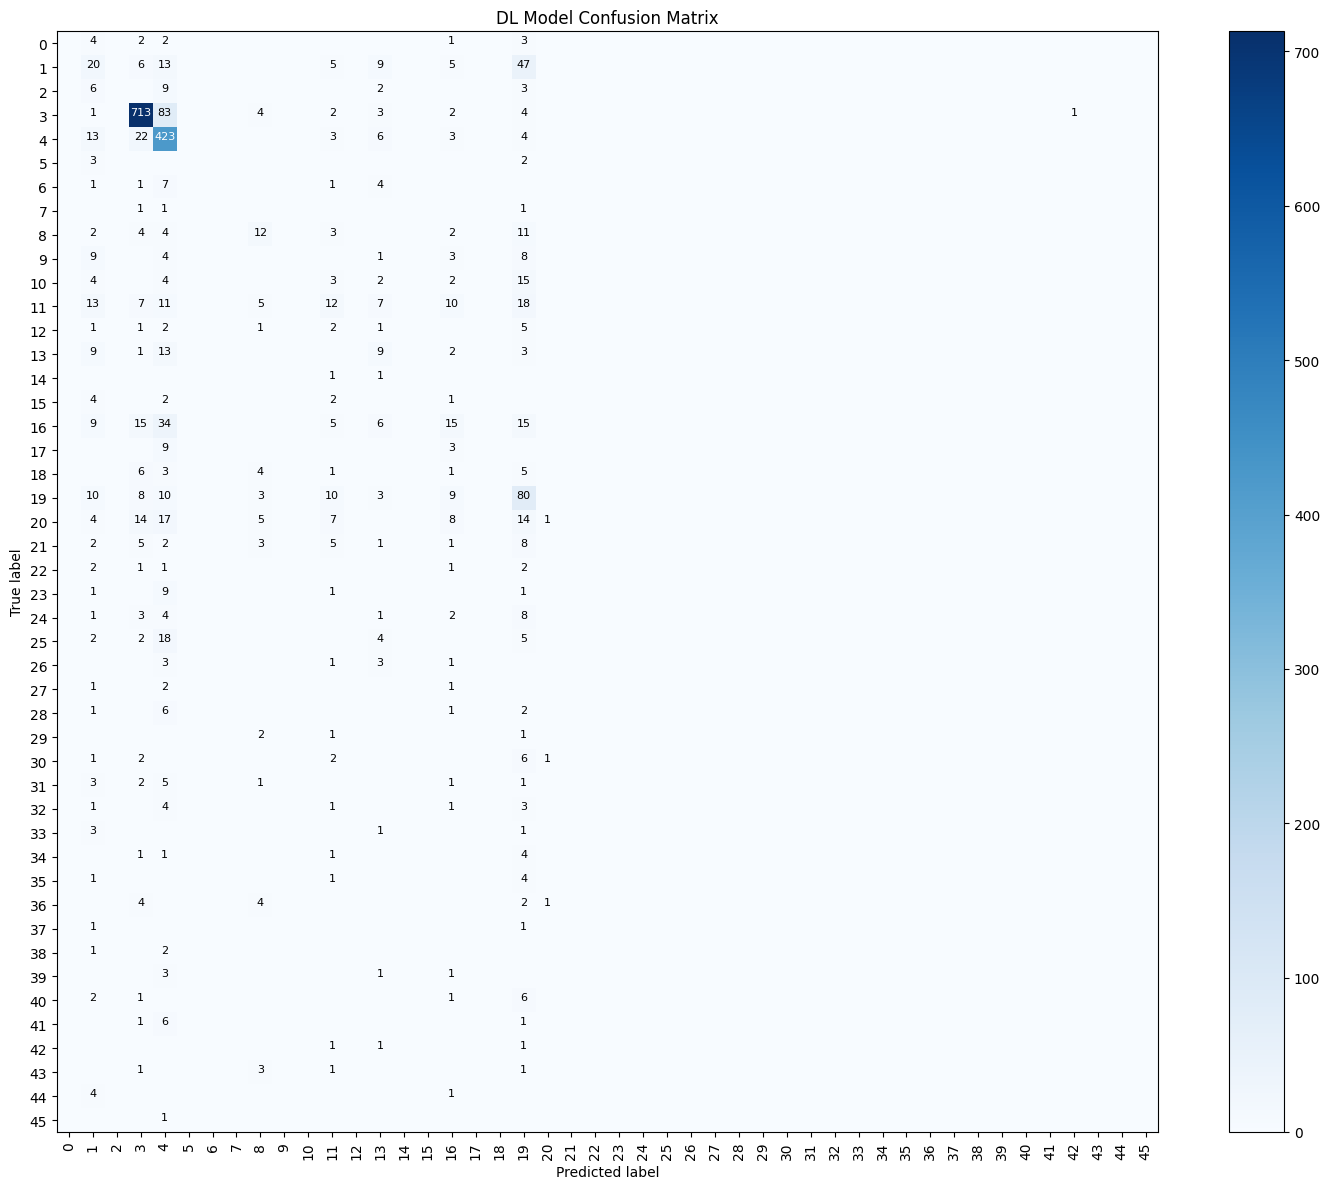

In [21]:
# Confusion Matrix for DL Model
cm_dl = confusion_matrix(y_test, y_pred_dl)
plot_confusion_matrix(cm_dl, classes=np.unique(y_train), title='DL Model Confusion Matrix')
plt.show()

#### 5.2. Comparing ML and DL

Index(['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score',
       'Training Time (s)', 'Memory Usage (MB)'],
      dtype='object')
Index(['Model', 'Accuracy'], dtype='object')


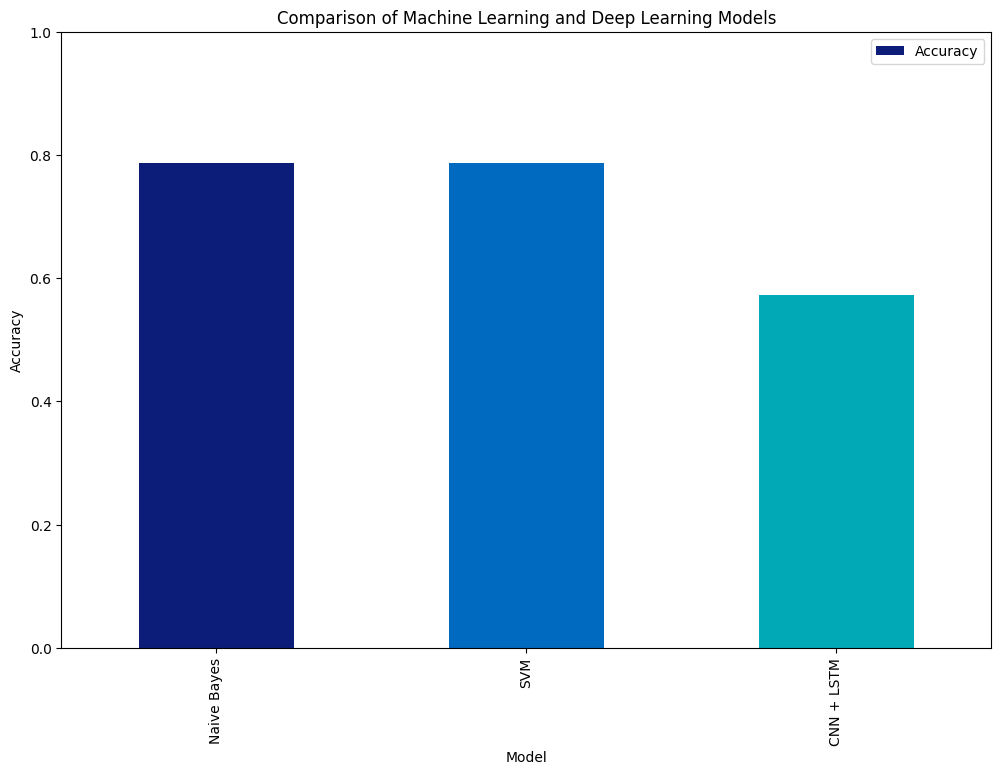

In [28]:
# Comparison of ML and DL Models
'''all_results_df = pd.concat([ml_results_df[['Accuracy']], pd.DataFrame(dl_results, columns=['Model', 'Accuracy']).set_index('Model')])
all_results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Comparison of Machine Learning and Deep Learning Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()'''# 머신 러닝 및 딥 러닝 모델 비교
# 'Model'을 열로 포함하도록 dl_results DataFrame의 인덱스를 재설정합니다.
# dl_results_df = pd.DataFrame(dl_results, columns=['Model', 'Accuracy']).set_index('Model').reset_index()
# dl_results_df = pd.DataFrame(dl_results, columns=['Model', 'Accuracy', 'val_accuracy', 'loss'])[['Model', 'Accuracy']].set_index('Model').reset_index()

# 'Model'을 열로 포함하도록 dl_results DataFrame의 인덱스를 재설정합니다.
# dl_results_df = pd.DataFrame(dl_results, columns=['Model', 'Accuracy']).set_index('Model').reset_index()
dl_results_df = pd.DataFrame(dl_results, columns=['Model', 'Accuracy', 'val_accuracy', 'loss'])[['Model', 'Accuracy']].set_index('Model').reset_index()
# 두 DataFrame 모두 동일한 열 구조를 갖도록 연결합니다.
# Check if 'Model' is a column in both DataFrames
print(ml_results_df.columns)
print(dl_results_df.columns)

# If 'Model' is not a column in ml_results_df, but it is the index, reset the index
if 'Model' not in ml_results_df.columns and ml_results_df.index.name == 'Model':
    ml_results_df = ml_results_df.reset_index()

# Now perform the concatenation
all_results_df = pd.concat([ml_results_df[['Model', 'Accuracy']], dl_results_df[['Model','Accuracy']]], ignore_index=True)
all_results_df.plot(x='Model', y='Accuracy', kind='bar', figsize=(12, 8), color=['#0b1d78', '#0069c0', '#00a9b5'])
# all_results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Comparison of Machine Learning and Deep Learning Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


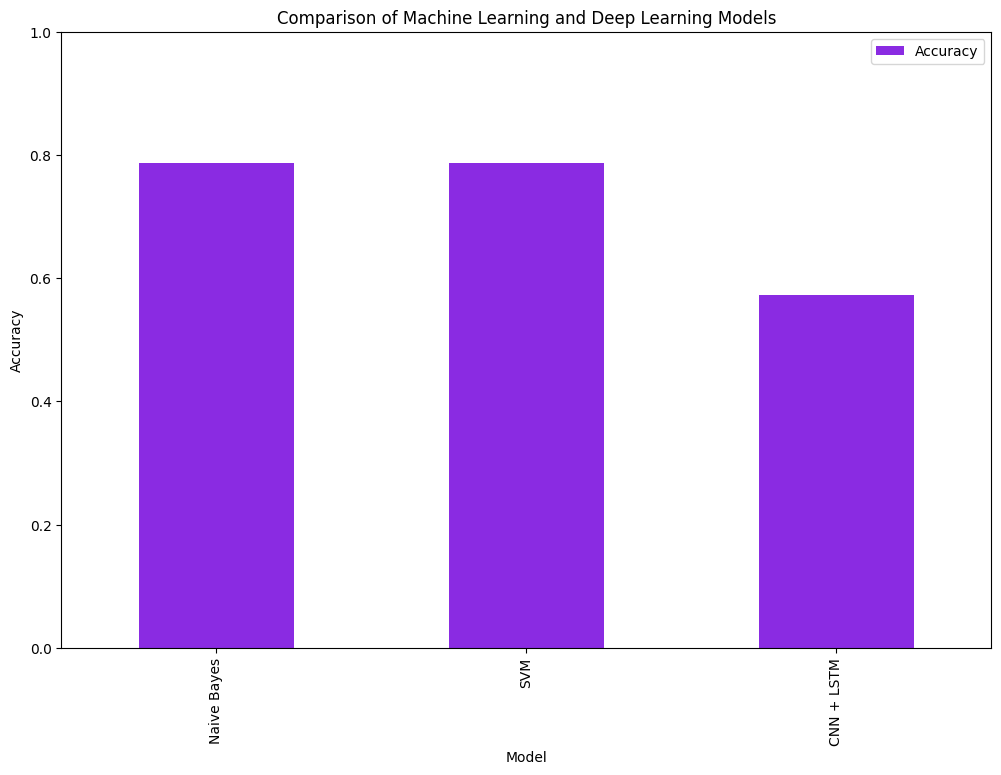

In [30]:
# Comparison of ML and DL Models : time included
all_results_df = pd.concat([ml_results_df[['Accuracy']], pd.DataFrame(dl_results, columns=['Model', 'Accuracy', 'Training Time (s)', 'Memory Usage (MB)']).set_index('Model')])
all_results_df[['Accuracy']].plot(kind='bar', figsize=(12, 8), color=['#8A2BE2', '#DC143C'])
plt.title('Comparison of Machine Learning and Deep Learning Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()